In [17]:
import os

import IPython.display as ipd
import keras
import librosa
import matplotlib.pyplot as plt 
import numpy as np
import random
import seaborn as sns
import tensorflow as tf

from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPool2D, Reshape

In [ ]:
# Using the standardized 2-second truncated audio files

train_real_directory = "for-2sec/for-2seconds/training/real"
train_fake_directory = "for-2sec/for-2seconds/training/fake"

validation_real_directory = "for-2sec/for-2seconds/validation/real"
validation_fake_directory = "for-2sec/for-2seconds/validation/fake"

test_real_directory = "for-2sec/for-2seconds/testing/real"
test_fake_directory = "for-2sec/for-2seconds/testing/fake"

In [19]:
# Get waveform (.wav) audio files

train_real_audio = [os.path.join(train_real_directory, file) for file in os.listdir(train_real_directory) if file.endswith('.wav')]
train_fake_audio = [os.path.join(train_fake_directory, file) for file in os.listdir(train_fake_directory) if file.endswith('.wav')]

validation_real_audio = [os.path.join(validation_real_directory, file) for file in os.listdir(validation_real_directory) if file.endswith('.wav')]
validation_fake_audio = [os.path.join(validation_fake_directory, file) for file in os.listdir(validation_fake_directory) if file.endswith('.wav')]

test_real_audio = [os.path.join(test_real_directory, file) for file in os.listdir(test_real_directory) if file.endswith('.wav')]
test_fake_audio = [os.path.join(test_fake_directory, file) for file in os.listdir(test_fake_directory) if file.endswith('.wav')]

In [20]:
# Taking a random audio file
random_audio_file = train_real_audio[random.randint(0, 6977)]
ipd.Audio(random_audio_file)

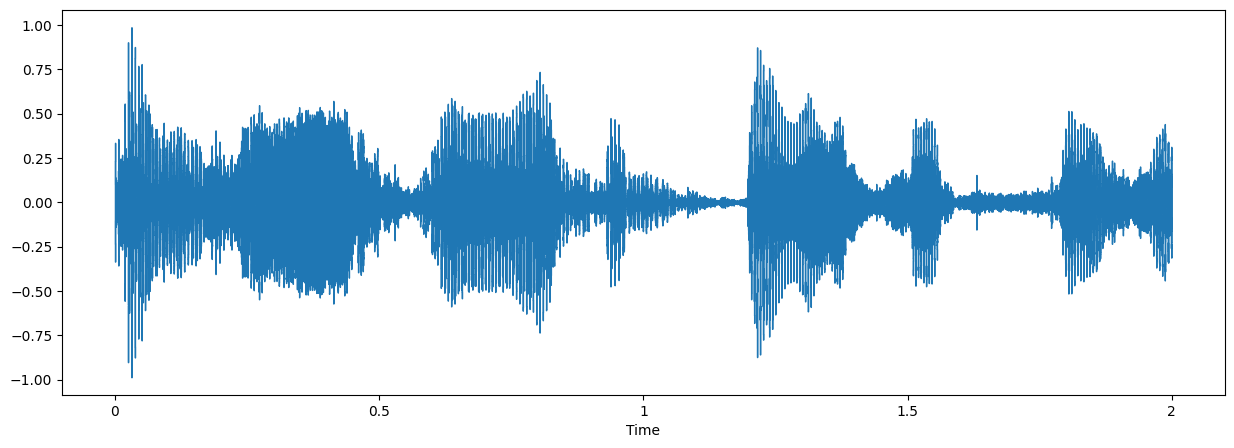

In [21]:
# Visualize waveform of sample audio above
# sr (sample rate) refers to the frequency of "snapshots" of the audio used for digital representation
audio_data, sample_rate = librosa.load(random_audio_file)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(audio_data, sr=sample_rate)

In [22]:
# Convert audio file to spectrogram
# def create_spectrogram(file_path):
#     audio_data, sample_rate = librosa.load(file_path)
#     spectrogram = librosa.stft(audio_data)
#     decibel_spectrogram = librosa.amplitude_to_db(abs(spectrogram))
#     return decibel_spectrogram

# Convert audio file to mel-scale spectrogram
# See https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53
def create_mel_spectrogram(file_path):
    audio_data, sample_rate = librosa.load(file_path)  
    # Convert audio to mel-based spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
    # Convert from amplitude squared to decibel units
    mel_decibel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)  
    return mel_decibel_spectrogram

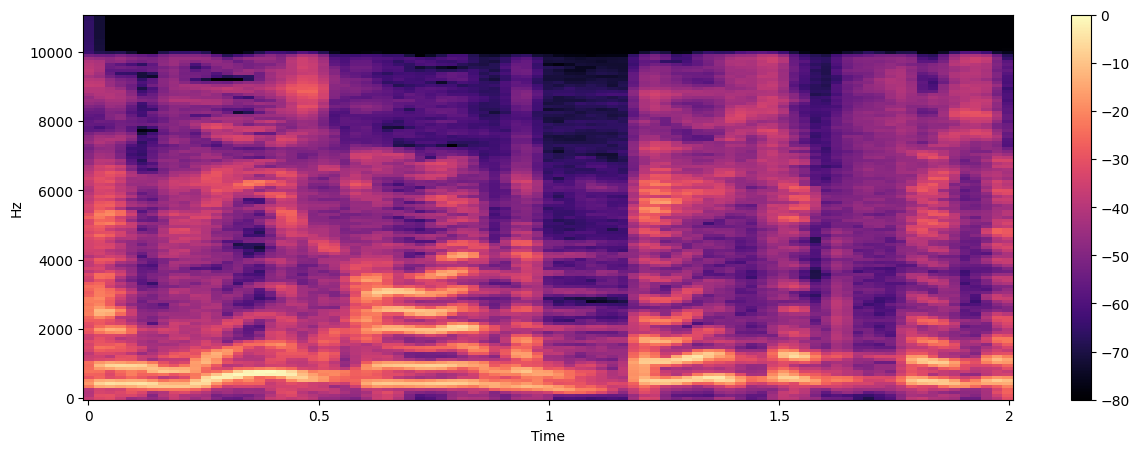

In [23]:
# Spectrogram representation of the sample wave form above
sample_spectrogram = create_mel_spectrogram(random_audio_file)
plt.figure(figsize=(15, 5))
librosa.display.specshow(sample_spectrogram, x_axis='time', y_axis='hz')
plt.colorbar()

In [24]:
# Use spectrograms as features to train the model
def get_features_and_labels(real_audio_files, fake_audio_files):
    spec_arr = []
    labels = []
    
    for file in real_audio_files:
        spectrogram = create_mel_spectrogram(file)
        spec_arr.append(spectrogram)
        labels.append(0)
    for file in fake_audio_files:
        spectrogram = create_mel_spectrogram(file)
        spec_arr.append(spectrogram)
        labels.append(1)
    
    return np.array(spec_arr), np.array(labels)

train_features, train_labels = get_features_and_labels(train_real_audio, train_fake_audio)
validation_features, validation_labels = get_features_and_labels(validation_real_audio, validation_fake_audio)
test_features, test_labels = get_features_and_labels(test_real_audio, test_fake_audio)

In [25]:
# From here on, we can use CNNs like in our Deepfake Image Detection Bot

# Big picture, we've essentially converted audio into images for machine learning

In [26]:
print("train features shape: {}".format(train_features.shape))
print("test features shape: {}".format(test_features.shape))

train features shape: (13956, 128, 87)
test features shape: (1088, 128, 87)


In [27]:
# Significantly trimmed VGG model to optimize results

trimmed_vgg = Sequential()
trimmed_vgg.add(Reshape((128, 87, 1),input_shape=train_features.shape[1:]))

trimmed_vgg.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation='relu'))
trimmed_vgg.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation='relu'))
trimmed_vgg.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

trimmed_vgg.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation='relu'))
trimmed_vgg.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation='relu'))
trimmed_vgg.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

trimmed_vgg.add(Flatten())
trimmed_vgg.add(Dense(units=256,activation="relu"))
trimmed_vgg.add(Dense(units=256,activation="relu"))
trimmed_vgg.add(Dense(1, activation="sigmoid"))

trimmed_vgg.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)             │ (None, 128, 87, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 87, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 87, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 43, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 43, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86016)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │    22,020,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,345,409 (85.24 MB)

 Trainable params: 22,345,409 (85.24 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Compile model
# Adam optimiser helps model get unstuck when stuck at local minima
trimmed_vgg.compile(optimizer=keras.optimizers.Adam(),
                    loss=keras.losses.binary_crossentropy, 
                    metrics=["accuracy"])

In [29]:
trimmed_vgg_history = trimmed_vgg.fit(train_features,
                                      train_labels,
                                      validation_data = [validation_features, validation_labels],
                                      batch_size = 32,
                                      epochs = 10,
                                      steps_per_epoch = 300)

Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - accuracy: 0.6192 - loss: 4.2808 - val_accuracy: 0.9048 - val_loss: 0.2356
Epoch 2/10
137/300 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.9069 - loss: 0.2105

I0000 00:00:1739076433.919684     113 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_3', 168 bytes spill stores, 168 bytes spill loads



300/300 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.9132 - loss: 0.2013 - val_accuracy: 0.9554 - val_loss: 0.1180
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - accuracy: 0.9594 - loss: 0.1100 - val_accuracy: 0.9777 - val_loss: 0.0607
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.9747 - loss: 0.0695 - val_accuracy: 0.9759 - val_loss: 0.0719
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - accuracy: 0.9857 - loss: 0.0361 - val_accuracy: 0.9791 - val_loss: 0.0596
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.9913 - loss: 0.0242 - val_accuracy: 0.9774 - val_loss: 0.0654
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - accuracy: 0.9907 - loss: 0.0318 - val_accuracy: 0.9837 - val_loss: 0.0491
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.9938 - loss: 0.0173 - val_accuracy: 0.9950 - val_loss: 0.0191
Epoch 9/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 17s 55ms/step - accuracy: 0.9978 - loss: 0.0065 - val_accuracy: 0

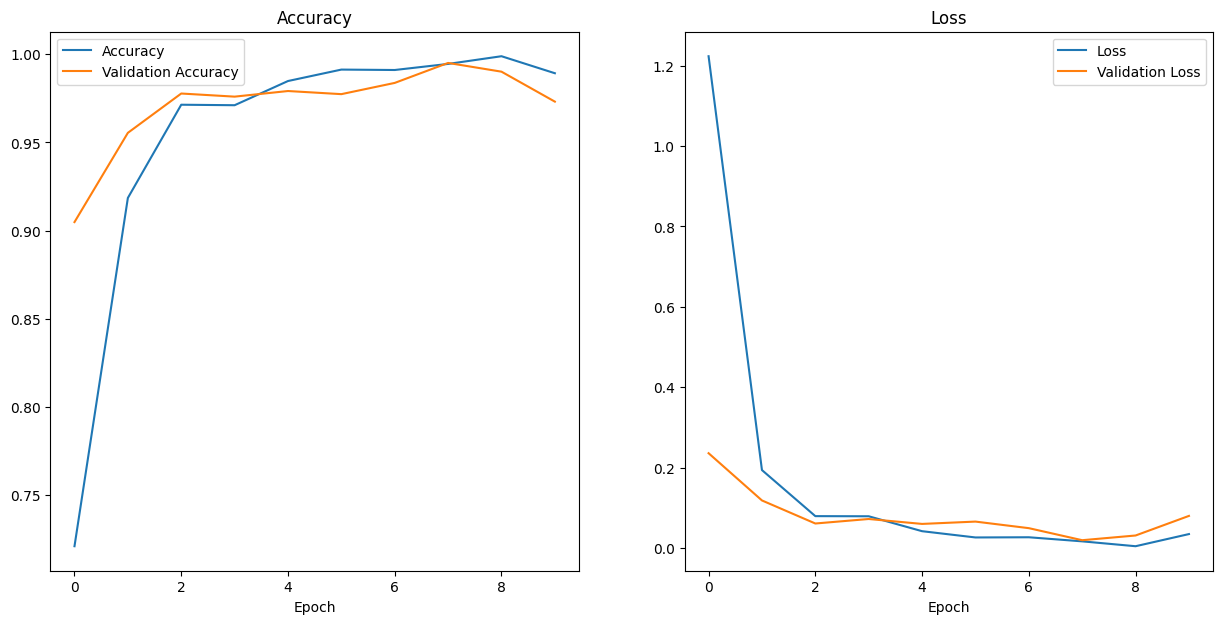

In [30]:
# Note that extremely high accuracy is not due to model overfitting,
# it's because the dataset is very "easy" relative to actual modern state of deepfaked audio
# i.e. the fakes are mostly easily detectable, even to the human ear

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

ax1.plot(trimmed_vgg_history.history["accuracy"])
ax1.plot(trimmed_vgg_history.history['val_accuracy'])
ax1.set_title("Accuracy")
ax1.set_xlabel("Epoch")
ax1.legend(["Accuracy","Validation Accuracy"])

ax2.plot(trimmed_vgg_history.history["loss"])
ax2.plot(trimmed_vgg_history.history["val_loss"])
ax2.set_title("Loss")
ax2.set_xlabel("Epoch")
ax2.legend(["Loss","Validation Loss"])

plt.show()

In [31]:
# Test Data Results

trimmed_vgg_loss, trimmed_vgg_accuracy = trimmed_vgg.evaluate(test_features, test_labels)

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9450 - loss: 0.2380


In [32]:
# Saving the final version

trimmed_vgg.save('deepfake_audio_detector.h5')